# Exponential Holder Bound

In [4]:
import jax
import numpy as np
import scipy
from scipy.stats import norm, beta
import matplotlib.pyplot as plt

This notebook studies the behavior of the "exponential H&ouml;lder bound".
Let us consider the simple z-test:
\begin{align*}
    X &\sim N(\theta, 1) \\
    H_0: \theta \leq 0 &\quad H_1: \theta > 0
\end{align*}
with $\sigma$ known.

The most powerful test is the usual one given by $\phi(x) = 1$ if $x > z_{1-\alpha}$,
where $z_{1-\alpha}$ is the $1-\alpha$ quantile of the standard normal distribution.
Then, the Type I Error function is
\begin{align*}
    f(\theta) &:= 1-\Phi\left(z_{1-\alpha}-\theta\right) \\
    \nabla f(\theta) &= \phi\left(z_{1-\alpha}-\theta\right)
\end{align*}
where $\theta$ is the natural parameter
and $\Phi(\theta), \phi(\theta)$ are the CDF, PDF of thise standard normal distribution, respectively.

We will compare this new bound with the other bounds developed previously.

The following are general helper functions that will be used throughout the notebook.

In [5]:
def simulate(theta_0, n_sims, alpha):
    '''
    Simulates the model described above n_sims times under theta_0
    and computes the Type I sum and score with optimal threshold
    at level alpha.
    '''
    xs = np.random.normal(theta_0, 1, n_sims)
    z_crit = norm.ppf(1 - alpha)
    rejs = xs > z_crit
    typeI_sum = np.sum(rejs)
    typeI_score = np.sum((xs - theta_0) * rejs)
    return typeI_sum, typeI_score

## Taylor Bound

The first upper bound we revisit is the Taylor bound.
The Taylor bound is given by
\begin{align*}
    f(\theta_0 + v)
    &\leq
    f(\theta_0) + \nabla f(\theta_0) v + U_R(v)
\end{align*}
where
\begin{align*}
    \int_0^1 (1-\alpha) \frac{d^2}{d\theta^2} f(\theta_0+\alpha v) v^2 d\alpha \leq U_R(v)
\end{align*}
for some convex function $U_R$.
By Lemma 9 in the draft of paper, we may take
\begin{align*}
    U_R(v) = \frac{1}{2} v^2
\end{align*}

The empirical upper bound estimate must take into account the randomness of our zeroth and first order terms.
The empirical upper bound is given by:
\begin{align*}
    \hat{U}(\theta_0+v)
    &=
    \hat{U}_0 + \hat{\Delta}(v) + U_R(v)
    \\
    \hat{\Delta}(v) 
    &= 
    \frac{1}{N} \sum\limits_{i=1}^N (X_i-\theta_0) F(X_i)v + 
    \frac{1}{2} \sqrt{\frac{v^2}{N} \left(\frac{1}{\delta_2} - 1 \right)}
\end{align*}
where $\hat{U}_0$ is the Clopper-Pearson estimate at $\theta_0$ with confidence $1-\delta_1$,
$F(x)$ is the indicator that the test falsely rejects with data $x$ generated from $\theta_0$,
and $N$ is the number of simulations.

In [6]:
def taylor_bound(f0, df0, vs):
    '''
    Computes the Taylor upper bound with true Type I Error and its gradient.
    '''
    return f0 + df0 * vs + (1 / 2) * vs**2

def taylor_bound_est(typeI_sum, typeI_score, nsims, vs, delta=0.025, delta_prop_0to1=0.5):
    '''
    Computes the Taylor upper bound with estimates and accounting for their error.
    '''
    f0 = beta.ppf(1 - (delta * delta_prop_0to1), typeI_sum + 1, nsims - typeI_sum)

    grad_est = typeI_score / nsims * vs
    covars = vs**2
    grad_bound = 0.5 * np.sqrt(covars / nsims * (1 / ((1 - delta_prop_0to1) * delta) - 1))

    hess_bound = covars / 2

    return f0 + (grad_est + grad_bound) + hess_bound

## H&ouml;lder Bound (Centered)

The centered H&ouml;lder bound centered by $c$ with conjugates $p, q \geq 1$ is given by
\begin{align*}
    f(\theta_0 + v)
    &\leq
    \frac{1}{A} \left(\frac{A C_q}{q} + (A f(\theta_0) + B)^{\frac{1}{q}}\right)^q - \frac{B}{A}
    \\
    C_q 
    &:= 
    \sup\limits_{v \in H-\theta_0} \int_0^1 || \frac{d}{dh} \log p_{\theta_0+hv}(X)||_{L^q(P_{\theta_0+hv})} dh
    \\
    p &:= \frac{q}{q-1} \\
    A &:= (1-c)^p - c^p \\
    B &:= c^p 
\end{align*}

We simplify $C_q$.
\begin{align*}
    \log p_{\theta}(x) &= - \frac{(x-\theta)^2}{2} + C
    \\ \implies
    \frac{d}{dh} \log p_{\theta_0+hv}(x) 
    &=
    (x-(\theta_0+hv))v
    \\ \implies
    ||\frac{d}{dh} \log p_{\theta_0+hv}(X)||_{L^q}
    &=
    |v| \cdot \mathbb{E}\left[|Z|^q \right]^\frac{1}{q}
\end{align*}
By simple calculus, one can show
\begin{align*}
    ||Z||_{L^q}
    &=
    \sqrt{2} \left(\frac{\Gamma\left(\frac{q+1}{2}\right)}{2\sqrt{\pi}}\right)^{\frac{1}{q}}
\end{align*}
Hence,
\begin{align*}
    C_q = ||Z||_{L^q} \sup\limits_{v \in H-\theta_0} |v|
\end{align*}

Finally, we have the following as the optimal choice for the centering
\begin{align*}
    c^* := \frac{1}{1 + \left(\frac{1-f(\theta_0)}{f(\theta_0)}\right)^{\frac{1}{p-1}}}
\end{align*}

In [7]:
def z_lq(q):
    frac = scipy.special.gamma((q+1)/2) / (2 * np.sqrt(np.pi))
    return np.sqrt(2) * frac**(1/q)

def C_q(vs, q):
    return z_lq(q) * vs
    
def copt(f0, p):
    return 1/(1 + ((1-f0) / f0)**(1/(p-1)))

def holder_bound(f0, vs, hp, hc='opt'):
    if hc == 'opt':
        hc = copt(f0, hp)
    hq = 1 / (1 - 1 / hp)
    B = hc**hp
    A = (1-hc)**hp - B
    C = C_q(vs, hq)
    return 1/A * (A*C/hq + (A*f0 + B)**(1/hq))**hq - B/A

## Exponential H&ouml;lder Bound

The exponential H&ouml;lder bound is given by
\begin{align*}
f(\theta_0 + v)
&\leq
1 - (1-f(\theta_0)) \exp\left[-\frac{\nabla f(\theta_0)^\top v}{1-f(\theta_0)} - S(v)\right]
\end{align*}
where
\begin{align*}
S(v) := A(\theta_0+v) - A(\theta_0) - \nabla A(\theta_0)^\top v
\end{align*}
and $A$ is the log-partition function.
In the Gaussian data case,
\begin{align*}
A(\theta) := \frac{\theta^2}{2}
\end{align*}
This gives us
\begin{align*}
S(v) 
&= \frac{1}{2} \left((\theta_0+v)^2 - \theta_0^2\right) - \theta_0 v
= \frac{v (2\theta_0+v)}{2} - \theta_0 v
= \frac{v^2}{2}
\end{align*}

In [8]:
def exp_holder_bound(f0, df0, vs):
    f0c = 1 - f0
    Svs = vs**2 / 2
    expos = df0 * vs / f0c + Svs
    return 1 - f0c * np.exp(-expos)

## Exponential Holder Improved?

In [16]:
def exp_holder_impr_bound(f0, vs):
    return np.exp(-0.5 * (vs - np.sqrt(-2*np.log(f0)))**2)

## Performance Comparison

In [33]:
theta_0 = -1
v_max = 1
n_steps = 20
alpha = 0.025

In [34]:
z_crit = norm.ppf(1-alpha)
f0 = 1-norm.cdf(z_crit - theta_0)
df0 = norm.pdf(z_crit - theta_0) 
vs = np.linspace(0, v_max, n_steps)

In [35]:
def run(theta_0, f0, df0, vs, alpha, z_crit, hp, hc):
    # compute true Type I Error
    thetas = theta_0 + vs
    fs = 1-norm.cdf(z_crit - thetas)

    # compute taylor bound
    taylor_bounds = taylor_bound(f0, df0, vs)

    # compute holder centered bound
    holder_bounds = [holder_bound(f0, vs, hp, c) for c in hc]

    # compute exp holder bound
    exp_holder_bounds = exp_holder_bound(f0, df0, vs)
    
    # compute exp holder impr bound
    exp_holder_impr_bounds = exp_holder_impr_bound(f0, vs)

    # plot everything
    plt.plot(thetas, fs, ls='--', color='black', label='True TIE')
    plt.plot(thetas, taylor_bounds, ls='-', label='taylor')
    for i, c in enumerate(hc):
        plt.plot(thetas, holder_bounds[i], ls='--', label=f'centered-holder({c}), p={hp}')
    plt.plot(thetas, exp_holder_bounds, ls='-.', label='exp-holder')
    plt.plot(thetas, exp_holder_impr_bounds, ls=':', label='exp-holder-impr')
    plt.legend()
    plt.show()

We first compare the performance of all the methods with various centering for centered-Holder method.
Since exponential Holder bound is inherently a Cauchy-Schwarz bound,
we first compare with $p = 2$ for centered-Holder.

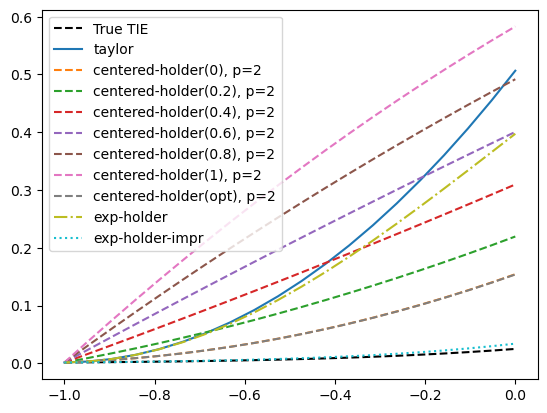

In [36]:
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=2,
    hc=[0, 0.2, 0.4, 0.6, 0.8, 1, 'opt'],
)

It's clear from the above that no centering and optimal centering are nearly identical.
Removing the other versions and keeping the optimal centering, we get the following:

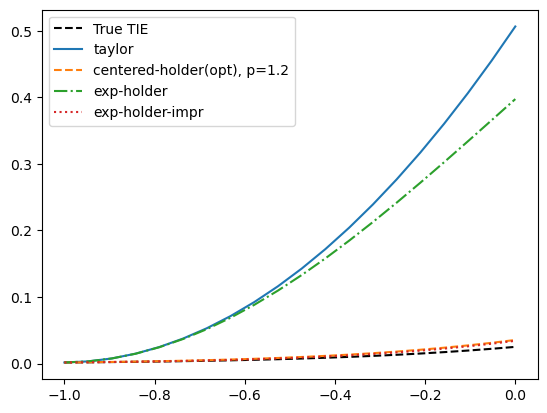

In [48]:
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=1.2,
    hc=['opt'],
)

We see that from $\theta_0$ (leftmost point), if we increase the tile size all the way until it hits the origin
(boundary of the null hypothesis), the exponential Holder bound does far worse than the centered Holder bound.
However, it is still uniformly better than the classical Taylor bound.

Zooming in on a smaller region around $\theta_0$, we get the following:

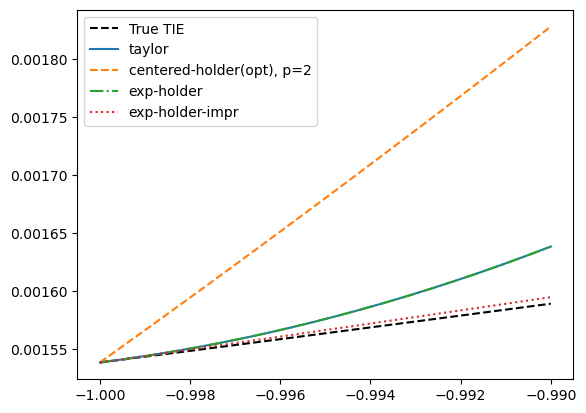

In [25]:
v_max = 0.01
vs = np.linspace(0, v_max, n_steps)
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=2,
    hc=['opt'],
)

Now we see that the exponential Holder is actually performing better than the optimally centered Holder method with $p=2$
in a smaller region around $\theta_0$.
Moreover, the Taylor expansion is nearly identical to the exponential Holder.

From a previous study, $p=1.2$ gave a good estimate for an improved bound for the centered Holder method.
The following shows the bound with $p=1.2$.

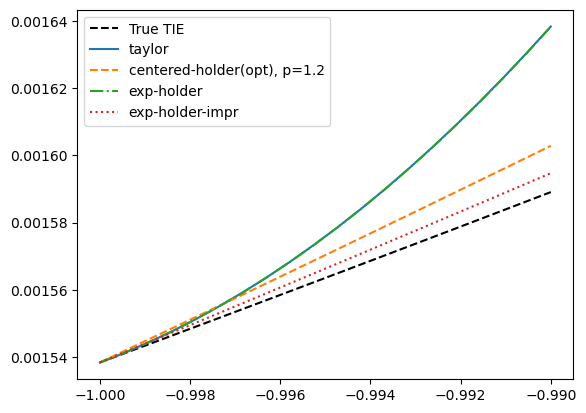

In [28]:
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=1.2,
    hc=['opt'],
)

The centered Holder bound is asymptotically performing better than the exponential Holder bound and Taylor bound.
However, for tile size of about $0.003$ (the usual gridding radius we consider in practice),
the two are nearly indistinguishable.

Now, we consider what happens when $\theta_0$ is closer to the boundary (when Type I Error at the simulation point is larger).

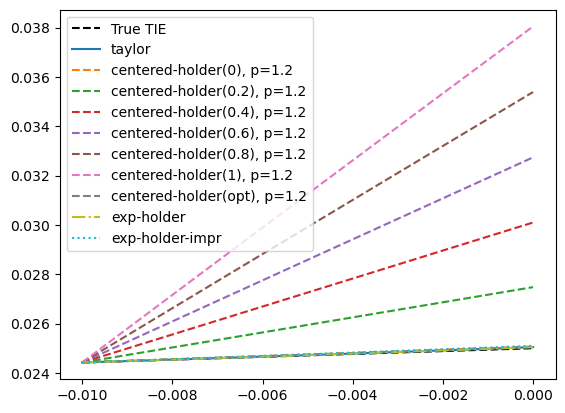

In [29]:
theta_0 = -0.01
v_max = -theta_0
f0 = 1-norm.cdf(z_crit - theta_0)
df0 = norm.pdf(z_crit - theta_0) 
vs = np.linspace(0, v_max, n_steps)
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=1.2,
    hc=[0, 0.2, 0.4, 0.6, 0.8, 1, 'opt'],
)

As before, clearly the best centered Holder occurs when the centering is small (close to 0).
Removing the others shows:

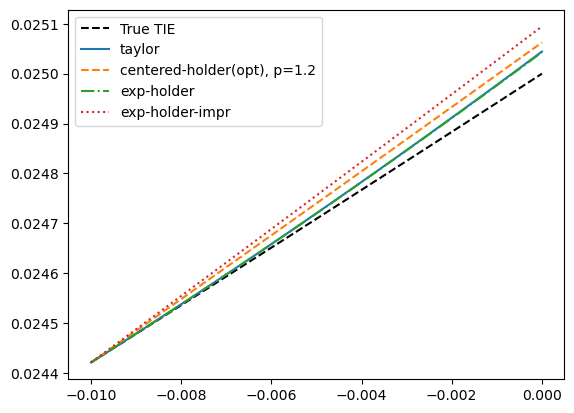

In [30]:
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=1.2,
    hc=['opt'],
)

Awesome! The exponential Holder bound is actually slightly better than the centered Holder bound!
Let's study the high Type I Error even more.
To simulate the scenario when the Type I Error might be high (possibly due to wrong specification of critical threshold),
let us take the current Gaussian setup with $\alpha = 0.3$.

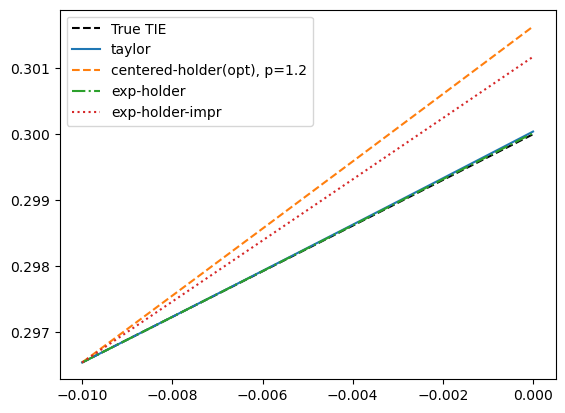

In [31]:
alpha = 0.3
z_crit = norm.ppf(1-alpha)
f0 = 1-norm.cdf(z_crit - theta_0)
df0 = norm.pdf(z_crit - theta_0) 
run(
    theta_0=theta_0,
    f0=f0,
    df0=df0,
    vs=vs,
    alpha=alpha,
    z_crit=z_crit,
    hp=1.2,
    hc=['opt'],
)

Amazing! Exponential Holder and Taylor are literally right on the true Type I Error whereas the centered Holder performs much worse.

### Final Remarks

- Taylor bound is surprisingly accurate for this example. This is largely due to the fact that the Taylor bound simplifies very nicely to a simple formula with few boundings necessary. It is partly a consequence that estimating $\theta$ is independent of $\sigma$, i.e. $\sigma$ is really a nuisance parameter. Things may look different with curved Gaussian when $\theta$ also governs the variance parameter. This is a good approximation of a test with Binomial data since with large enough sample size, Binomial is approximately Gaussian with mean $np$ and variannce $np(1-p)$ where $p = expit(\theta)$.

- Exponential Holder bound is also surprisingly accurate.
Especially when the Type I Error is large, it's surprising that it is robust.
Moreover, it beats Taylor with large enough tile size!
So, in some sense, it has more potential of being tighter to the true Type I Error.

- Centered Holder bound is very accurate in some regions, but I want to argue that it's not doing so well in cases that we care about.
When Type I Error is large, that's when we would like to be tightest, if possible.
When Type I Error is small, we have more budget to be wrong.
The above shows that centered Holder does extremely well with _large_ tile-size when Type I Error is low at $\theta_0$.
But within small regions around $\theta_0$,
which is the typical use-case when we construct grid-points,
it's doing worse than exponential Holder/Taylor.
And at large Type I Error at $\theta_0$, it does worse than exponential Holder/Taylor.